# Simulated Annealing for TSP

## C and T0 values

- Best trial for eil51_tsp_optimization:
  Value: 484.62
  Params: 
    T0: 364
    C: 0.737770677729471
    
- Best trial for a280_tsp_optimization:
  Value: 3050.04
  Params: 
    T0: 131
    C: 0.1618902602367022
    
- Best trial for pcb442_tsp_optimization:
  Value: 58562.82
  Params: 
    T0: 574
    C: 0.21932738777140884

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import sem, t
import pandas as pd
import os
from scipy.stats import ttest_1samp as t_test
from scipy.stats import ttest_ind as t_test_2_samp


In [38]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([float(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

def get_distance(city_a, city_b):
    '''Calculates distance between city a and city b.
    Input: numpy arrays of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)'''
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''Calculates the total distance of the route of visiting all cities in order specified.
    Input: OrderedDict of cities (keys) with their coordinates (np.arrays of x and y)
    Output: Total route distance (scalar)'''

    city_coords = list(cities.values())

    #Init variable: link last city with first
    total_distance = get_distance(city_coords[-1], city_coords[0])
    
    #Connect every subsequent pair of cities
    for i in range(len(cities) -1):
        total_distance += get_distance(city_coords[i], city_coords[i+1])

    return total_distance

def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()


In [39]:
#Open initial file, store cities with coordinates

filename = "TSP-Configurations/eil51.tsp.txt"
# filename = "TSP-Configurations/a280.tsp.txt"
# filename = "TSP-Configurations/pcb442.tsp.txt"
init_cities = get_city_coord_dict(filename)

In [40]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step=501, init_seed=np.random.randint(1, 1000)):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.step = 0
        self.max_step = max_step
        self.seed = init_seed

    def nearest_neighbor_heuristic(self):
        cities = list(self.cities_old.keys())
        current_city = np.random.choice(cities)
        solution = [current_city]

        while len(solution) < len(cities):
            distances = [(city, np.linalg.norm(np.array(self.cities_old[current_city]) - np.array(self.cities_old[city])))
                         for city in cities if city not in solution]
            next_city, _ = min(distances, key=lambda x: x[1])
            solution.append(next_city)
            current_city = next_city

        return OrderedDict((city, self.cities_old[city]) for city in solution)

    def proposal(self, cities):
        # Select a random key from the dictionary
        random_key = np.random.choice(list(cities.keys()))
        value = cities[random_key]

        proposal_cities = cities.copy()
        del proposal_cities[random_key]

        # Move it to here
        new_index = np.random.randint(0, len(cities) - 1)

        # Create a new dictionary with the rearranged order
        proposal_cities = OrderedDict(list(cities.items())[:new_index] + [(random_key, value)] + list(
            cities.items())[new_index:])
        return proposal_cities

    def two_opt(self, cities):
        i, j = np.random.choice(len(cities), size=2, replace=False)

        if i > j:
            i, j = j, i

        new_order = list(cities.items())[:i + 1] + list(reversed(list(cities.items())[i + 1:j + 1])) + list(
            cities.items())[j + 1:]
        return OrderedDict(new_order)

    def evaluate(self, cities, proposal_cities, T):
        dist_proposal_cities = total_distance(proposal_cities)
        dist_cities = total_distance(cities)
        alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)

        #(possibly) update best overall
        if dist_proposal_cities < dist_cities:
            self.best_overall = proposal_cities

        return alpha_func
    

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            #accept
            cities_new = proposal_cities
        else:
            #reject
            cities_new = self.cities_old

        return cities_new

    def exponential_cooling(self, step):
        return self.T0 * np.exp(-self.C * step)

    def linear_cooling(self, step):
        return self.T0 / (1 + self.C * step)

    def run(self, cooling_scheme, swap_scheme):
        self.cities_old = self.nearest_neighbor_heuristic()  # Initialize with nearest neighbor heuristic

        while self.step < self.max_step:
            self.seed += 1
            # The temperature scheme (the cooling scheme)
            if cooling_scheme == 'logarithmic':
                T = (self.C * np.log(self.step + self.T0)) ** (-1)
            elif cooling_scheme == 'exponential':
                T = self.exponential_cooling(self.step)
            elif cooling_scheme == 'linear':
                T = self.linear_cooling(self.step)
            else:
                raise ValueError("Invalid cooling_scheme. Choose from 'logarithmic', 'exponential', or 'linear'.")

            self.step = self.step + 1
            # 1. Proposal
            if swap_scheme == '2-opt':
                proposal_cities = self.two_opt(self.cities_old)
            elif swap_scheme == 'Single Node Swap':
                proposal_cities = self.proposal(self.cities_old)
            else:
                raise ValueError("Invalid swap_scheme. Choose from '2-opt' or 'Single Node Swap'.")

            # 2. Evaluate
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            # 3. Select
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new

# Optimal solution 

In [41]:
# Optimal solution
def get_optimal_sol(filename, cities_dict):
    '''Opens the file with cities ordered for an optimal path. Sorted input dictionary accordingly.
    Input: file name with path, city/coordinate dictionary to be sorted
    Ouput: Optimally sorted ordered dictionary of cities with corresponding x and y coordinates (numpy array)'''
    city_order = []

    with open(filename, 'r') as file:
        tour_section_started = False

        for line in file:
            line = line.strip()

            if tour_section_started and line[0].isdigit():
                city_order.append(int(line))
            elif line.startswith("TOUR_SECTION"):
                tour_section_started = True
            elif line.startswith("-1"):
                break
        
    opt_sol_dict = OrderedDict((key, cities_dict[key]) for key in city_order)
        
    return opt_sol_dict


In [42]:
#Compare with optimal solution
filename = "TSP-Configurations/eil51.opt.tour.txt" #adjust as needed
# filename = "TSP-Configurations/a280.opt.tour.txt"
# filename = "TSP-Configurations/pcb442.opt.tour.txt"

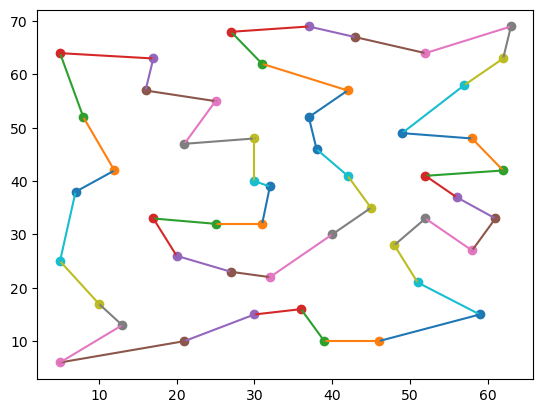

Total distance of optimal route is: 429.983311983384
Optimal order of the cities is as follows: odict_keys([1, 22, 8, 26, 31, 28, 3, 36, 35, 20, 2, 29, 21, 16, 50, 34, 30, 9, 49, 10, 39, 33, 45, 15, 44, 42, 40, 19, 41, 13, 25, 14, 24, 43, 7, 23, 48, 6, 27, 51, 46, 12, 47, 18, 4, 17, 37, 5, 38, 11, 32])


In [43]:
opt_sol_dict = get_optimal_sol(filename, init_cities)
visualize_routes(opt_sol_dict)
opt_solution_distance = total_distance(opt_sol_dict)
print(f'Total distance of optimal route is: {opt_solution_distance}')
print(f'Optimal order of the cities is as follows: {opt_sol_dict.keys()}')

# Run experiment, plots

/tmp/ipykernel_54332/468985446.py:53: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)
/tmp/ipykernel_54332/468985446.py:53: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)
/tmp/ipykernel_54332/468985446.py:53: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)
/tmp/ipykernel_54332/468985446.py:53: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)


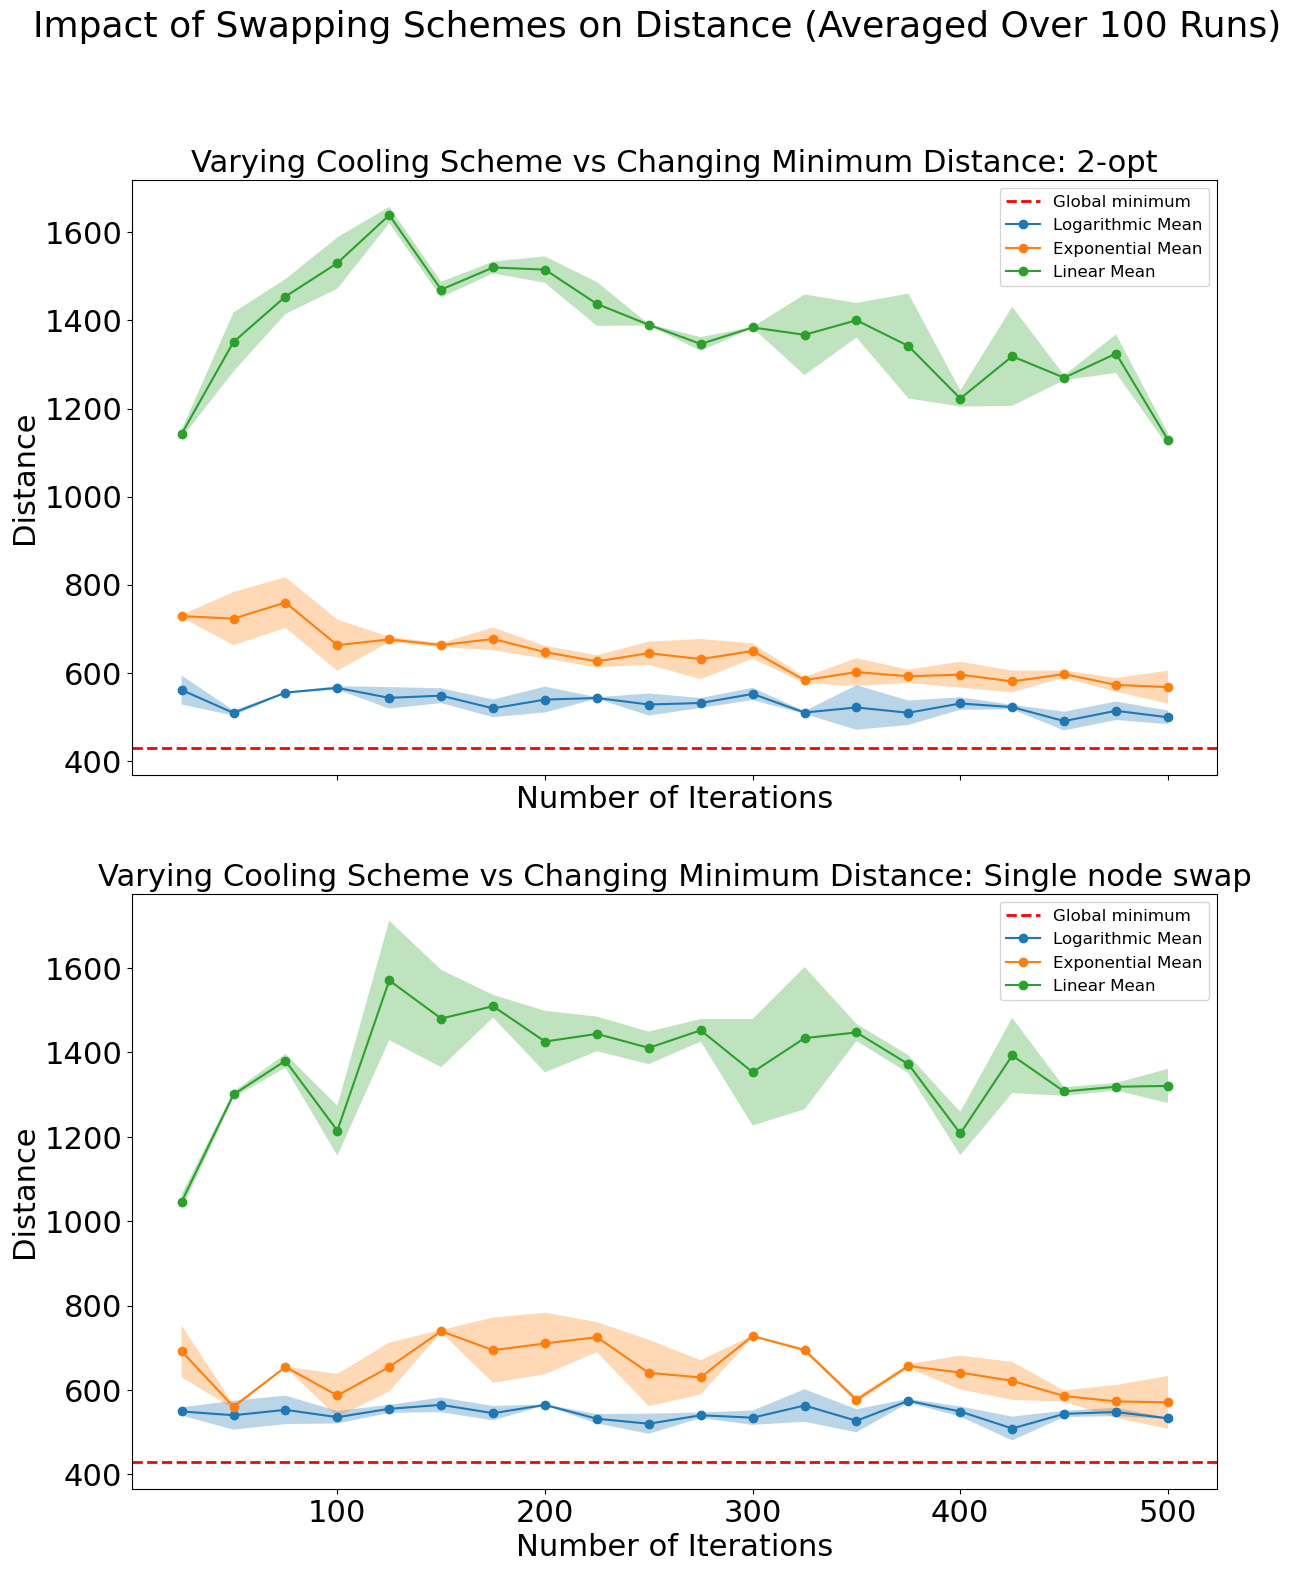

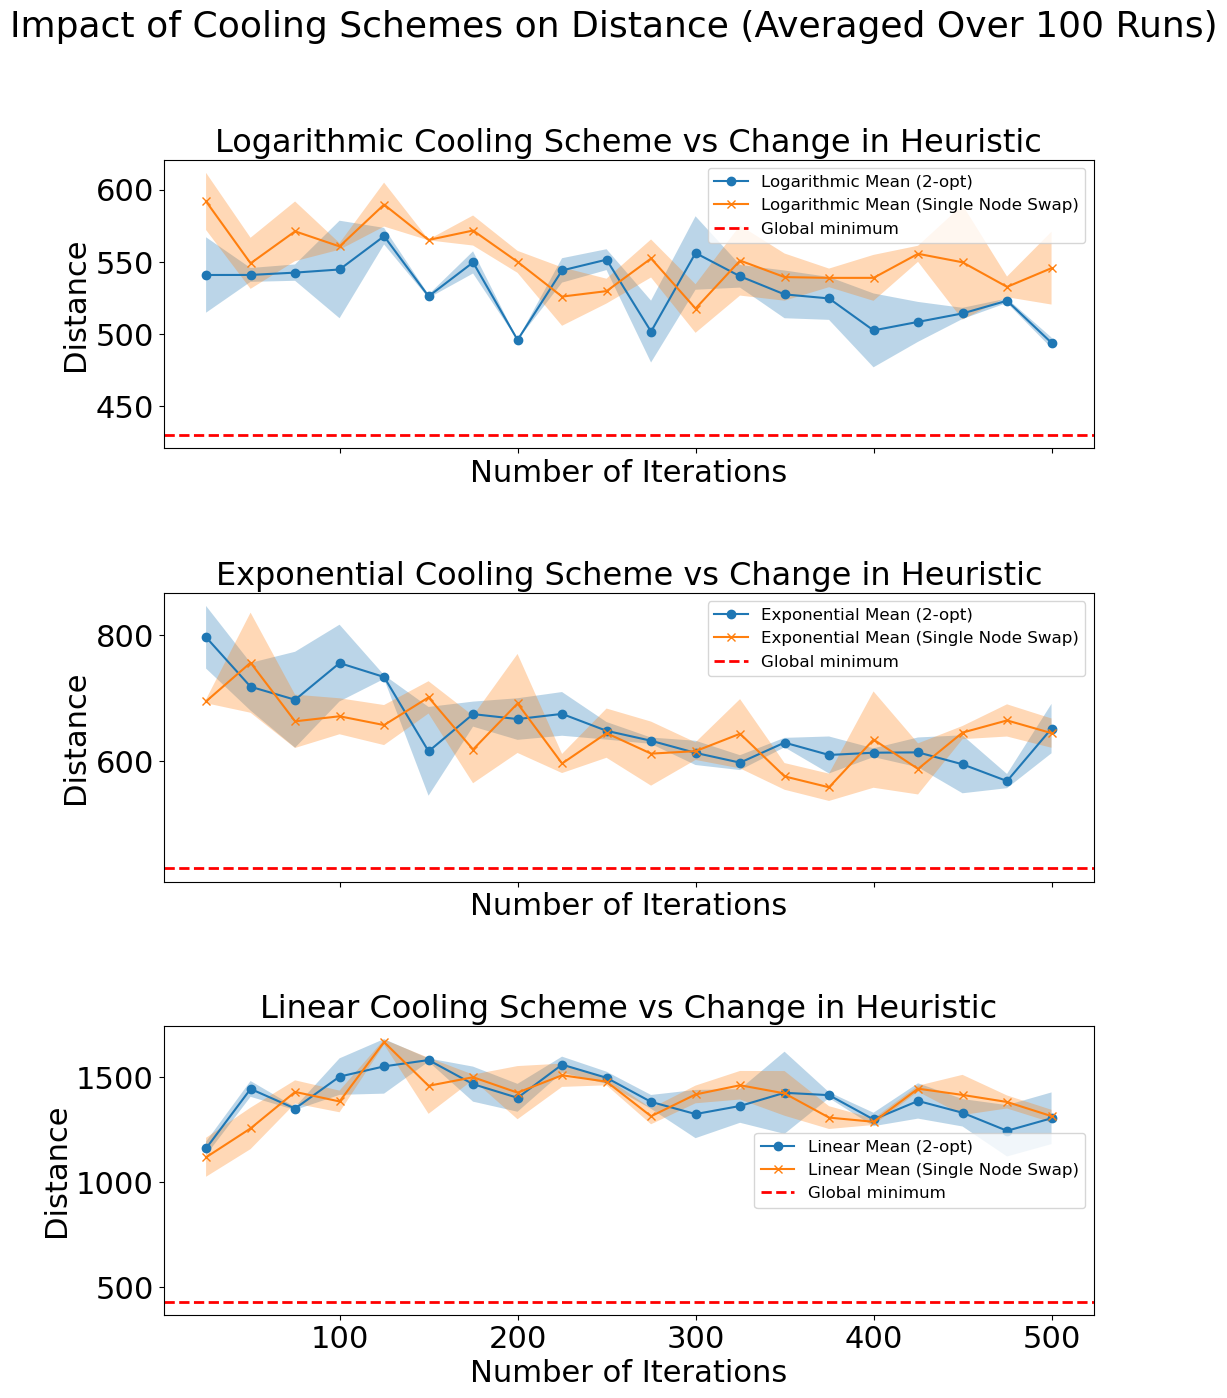

In [46]:
# Directory to save CSV files and plots
output_directory = "experiment_results"

# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the number of runs
num_runs = 2

# Function to run the experiment for a specific combination of cooling and swap schemes
def run_experiment(cooling_scheme, swap_scheme, max_iterations_range):
    results = {'Iteration': [], 'Distance': []}

    for max_iter in max_iterations_range:
        distances = []

        for run in range(num_runs):
            sa_instance = SimulatedAnnealing(init_cities, C=0.897485, T0=7895, max_step=max_iter, init_seed=np.random.randint(1, 1000))
            final_cities = sa_instance.run(cooling_scheme, swap_scheme)
            distance = total_distance(final_cities)
            
            distances.append(distance)
            
            # Store results for each run
            result_entry = {'Iteration': max_iter, 'Distance': distance}
            results['Iteration'].append(max_iter)
            results['Distance'].append(distance)

    # Create a DataFrame for the current combination of cooling and swap scheme
    df_results = pd.DataFrame(results)

    # Save the DataFrame to a CSV file
    output_file = os.path.join(output_directory, f'results_{cooling_scheme}_{swap_scheme}.csv')
    df_results.to_csv(output_file, index=False)

# Run the experiment for each combination of cooling and swap schemes
cooling_schemes = ['logarithmic', 'exponential', 'linear']
swap_schemes = ['2-opt', 'Single Node Swap']
max_iterations_range = np.arange(25, 501, 25)  # Adjust the range as needed

# Create subplots for each swapping scheme
fig, axs = plt.subplots(len(swap_schemes), 1, figsize=(14, 17), sharex=True, gridspec_kw={'hspace': 0.2})
fig.suptitle('Impact of Swapping Schemes on Distance (Averaged Over 100 Runs)', fontsize=26)

for i, swap_scheme in enumerate(swap_schemes):
    axs[i].axhline(y = opt_solution_distance, color = 'red', linestyle = '--', linewidth = 2, label = 'Global minimum')

    for j, cooling_scheme in enumerate(cooling_schemes):
        run_experiment(cooling_scheme, swap_scheme, max_iterations_range)
        df_results = pd.read_csv(os.path.join(output_directory, f'results_{cooling_scheme}_{swap_scheme}.csv'))
        
        # Calculate confidence intervals and add shaded areas
        mean_distance = df_results.groupby('Iteration')['Distance'].mean()
        std_error = df_results.groupby('Iteration')['Distance'].sem()
        axs[i].fill_between(mean_distance.index, mean_distance - std_error, mean_distance + std_error, alpha=0.3)
        
        # Plot only the average over the number of runs
        axs[i].plot(mean_distance.index, mean_distance, label=f'{cooling_scheme.capitalize()} Mean', marker='o')        

    axs[i].set_title(f'Varying Cooling Scheme vs Changing Minimum Distance: {swap_scheme.capitalize()}', fontsize=22)
    axs[i].set_ylabel('Distance', fontsize=22)
    axs[i].set_xlabel('Number of Iterations', fontsize=22) 
    axs[i].legend(fontsize=12)
    axs[i].tick_params(axis='both', labelsize=22)

# Save the plot as a PNG file
plt.savefig(os.path.join(output_directory, 'swapping_schemes_plot.png'))

# Create subplots for each cooling scheme with both swap schemes
fig, axs_cooling = plt.subplots(len(cooling_schemes), 1, figsize=(12, 15), sharex=True, gridspec_kw={'hspace': 0.5})
fig.suptitle('Impact of Cooling Schemes on Distance (Averaged Over 100 Runs)', fontsize=26)

for i, cooling_scheme in enumerate(cooling_schemes):
    for swap_scheme in swap_schemes:
        run_experiment(cooling_scheme, swap_scheme, max_iterations_range)
        
    # Create DataFrames for both swap schemes
    df_results_2opt = pd.read_csv(os.path.join(output_directory, f'results_{cooling_scheme}_2-opt.csv'))
    df_results_single_node = pd.read_csv(os.path.join(output_directory, f'results_{cooling_scheme}_Single Node Swap.csv'))
    
    # Calculate mean and standard error for error bars for 2-opt
    mean_distance_2opt = df_results_2opt.groupby('Iteration')['Distance'].mean()
    std_error_2opt = df_results_2opt.groupby('Iteration')['Distance'].sem()

    # Calculate mean and standard error for error bars for Single Node Swap
    mean_distance_single_node = df_results_single_node.groupby('Iteration')['Distance'].mean()
    std_error_single_node = df_results_single_node.groupby('Iteration')['Distance'].sem()

    axs_cooling[i].plot(mean_distance_2opt.index, mean_distance_2opt, label=f'{cooling_scheme.capitalize()} Mean (2-opt)', marker='o')
    axs_cooling[i].plot(mean_distance_single_node.index, mean_distance_single_node, label=f'{cooling_scheme.capitalize()} Mean (Single Node Swap)', marker='x')
    axs_cooling[i].axhline(y = opt_solution_distance, color = 'red', linestyle = '--', linewidth = 2, label = 'Global minimum')

    axs_cooling[i].set_title(f'{cooling_scheme.capitalize()} Cooling Scheme vs Change in Heuristic', fontsize=23)
    axs_cooling[i].set_ylabel('Distance', fontsize=22)
    axs_cooling[i].set_xlabel('Number of Iterations', fontsize=22) 
    axs_cooling[i].legend(fontsize=12)
    axs_cooling[i].tick_params(axis='both', labelsize=22)

    # Calculate confidence intervals and add shaded areas
    axs_cooling[i].fill_between(mean_distance_2opt.index, mean_distance_2opt - std_error_2opt, mean_distance_2opt + std_error_2opt, alpha=0.3)
    axs_cooling[i].fill_between(mean_distance_single_node.index, mean_distance_single_node - std_error_single_node, mean_distance_single_node + std_error_single_node, alpha=0.3)

# Save the plot as a PNG file
plt.savefig(os.path.join(output_directory, 'cooling_schemes_plot.png'))

plt.show()

# Statistical tests

In [96]:
max_iteration = 500 #adjust as needed
directory_path = 'experiment_results'

#Convergence: one-sample two-sided test
print('One sample t-test compared to the global mean')

for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        result_df = pd.read_csv(file_path)
        last_iteration_data = result_df[result_df['Iteration'] == max_iteration]['Distance']
        _, p_value = t_test(last_iteration_data, opt_solution_distance)
        print(f'P_value: {p_value:.2e} for filename: {filename}')

One sample t-test compared to the global mean
P_value: 2.17e-02 for filename: results_linear_Single Node Swap.csv
P_value: 8.91e-02 for filename: results_linear_2-opt.csv
P_value: 3.64e-02 for filename: results_logarithmic_2-opt.csv
P_value: 1.11e-01 for filename: results_exponential_2-opt.csv
P_value: 6.85e-02 for filename: results_exponential_Single Node Swap.csv
P_value: 1.37e-01 for filename: results_logarithmic_Single Node Swap.csv


In [94]:
#Comparing single node swap with 2-opt (two-sample t-test)

linear_swap_data = pd.read_csv("experiment_results/results_linear_Single Node Swap.csv").query(f'Iteration == {max_iteration}')['Distance'].tolist()
linear_2opt_data = pd.read_csv("experiment_results/results_linear_2-opt.csv").query(f'Iteration == {max_iteration}')['Distance'].tolist()

logarithmic_swap_data = pd.read_csv("experiment_results/results_logarithmic_Single Node Swap.csv").query(f'Iteration == {max_iteration}')['Distance'].tolist()
logarithmic_2opt_data = pd.read_csv("experiment_results/results_logarithmic_2-opt.csv").query(f'Iteration == {max_iteration}')['Distance'].tolist()

exponential_swap_data = pd.read_csv("experiment_results/results_exponential_Single Node Swap.csv").query(f'Iteration == {max_iteration}')['Distance'].tolist()
exponential_2opt_data = pd.read_csv("experiment_results/results_exponential_2-opt.csv").query(f'Iteration == {max_iteration}')['Distance'].tolist()


print('T-test 2-opt better than swap')
_, p_val  = t_test_2_samp(linear_2opt_data, linear_swap_data, alternative='less')
print(f'Linear: {p_val:.2e}')
_, p_val = t_test_2_samp(logarithmic_2opt_data, logarithmic_swap_data, alternative='less')
print(f'Log: {p_val:.2e}')
_, p_val = t_test_2_samp(exponential_2opt_data, exponential_swap_data, alternative='less')
print(f'Exponential: {p_val:.2e}')


T-test 2-opt better than swap
Linear: 4.72e-01
Log: 8.98e-02
Exponential: 5.56e-01


In [93]:
#Comparing cooling schemes (two-sample t-test)

p_exp_vs_linear_2opt = t_test_2_samp(exponential_2opt_data, linear_2opt_data, alternative='less').pvalue
p_log_vs_linear_2opt = t_test_2_samp(logarithmic_2opt_data, linear_2opt_data, alternative='less').pvalue
p_log_vs_exp_2opt = t_test_2_samp(logarithmic_2opt_data, exponential_2opt_data, alternative='less').pvalue

p_exp_vs_linear_swap = t_test_2_samp(exponential_swap_data, linear_swap_data, alternative='less').pvalue
p_log_vs_linear_swap = t_test_2_samp(logarithmic_swap_data, linear_swap_data, alternative='less').pvalue
p_log_vs_exp_swap = t_test_2_samp(logarithmic_swap_data, exponential_swap_data, alternative='less').pvalue

# Create a DataFrame for the table
data = {
    '': ['2-opt', '', 'Single Node Swap', ''],
    'E(Exp) < E(Linear)': ['', p_exp_vs_linear_2opt, '', p_exp_vs_linear_swap],
    'E(Log) < E(Linear)': ['', p_log_vs_linear_2opt, '', p_log_vs_linear_swap],
    'E(Log) < E(Exp)': ['', p_log_vs_exp_2opt, '', p_log_vs_exp_swap],
}

table_df = pd.DataFrame(data)
print(table_df)

                    E(Exp) < E(Linear) E(Log) < E(Linear) E(Log) < E(Exp)
0             2-opt                                                      
1                             0.018581            0.01118        0.028406
2  Single Node Swap                                                      
3                             0.001614           0.001305        0.050673
